__STA 208 Spring 2020__

__Group Members:__ Rongkui Han, Miao Hu, Connor Rosenberg, Yuqing Yang

______________________

# Introduction

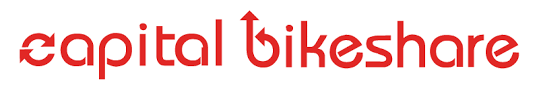

In [1]:
from IPython.display import Image
Image("../Capital-Bikeshare-Final-Project/Images/Logo.png")

Capital Bikeshare is a company in Washington, DC which provides residents, workers, and tourists a method of public transportation. The system operates 591 bike docks across the Washington, DC metro area where users can start and end their commute.

To use the bike network, customers walk to one of these docks and swipe their membership or credit card to unlock one of the station’s bikes. They then bike to another dock near their final destination and return the bike by locking it back into the new dock. Unlike other bikeshare services, whose bikes live freely on the street, this dock-to-dock system provides the exact start and end coordinates of every trip. This provides a great base to analyze route dynamics in Washington, DC as we can assume a high degree of integrity from the data.

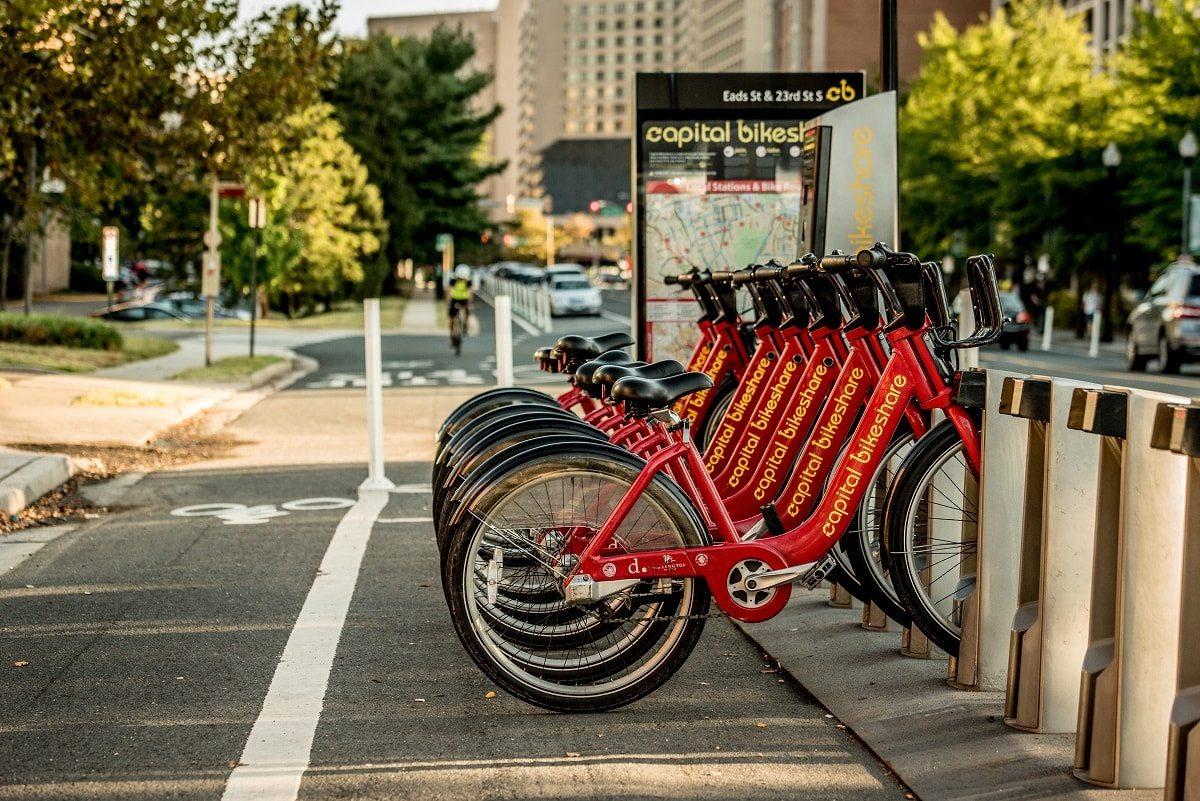

In [2]:
Image("../Capital-Bikeshare-Final-Project/Images/bikestation.jpg")

With 591 stations, the Capital Bikeshare network is used by many residents to commute to their place of work. Since the system provides such a useful service with limited capacity, the morning rush hour can place great strain on the network. For this reason, it is important to develop a method of forecasting a route's demand so workers can strategically place bikes overnight in preparation for riders' daily commute.  

The purpose of this project is to estimate the daily number of trips between each route in the Capital Bikeshare network during the morning rush, which we define between the hours of 5:00 AM and 10:00 AM. There are three primary phases of our analysis. First, we cluster each station based on the characteristics of the surrounding destinations. Next, we use these clusters as a new variable to predict if any trips occur along each daily route. Finally, we predict how many trips will occur on each route during the morning rush.

___________________________

In [3]:
import pandas as pd
import numpy as np
import time
import re
import seaborn as sns

# Clustering Stations

To better forecast route demand, we first need to learn additional information about each station. More specifically, we need to learn about the types of destinations that are proximal to each station. For example, a station located in Foggy Bottom is near the political and tourist hub of DC. We can, therefore, infer that trips made to these stations during the morning rush hour are likely to political staffers commuting to work. Similarly, stations in Adams Morgan are close to residential buildings and restaurants. We can infer that morning rush hour trips to these stations are likely night-shift workers returning home or restaurant staff preparing for the day. 

To capture this additional station information, we interfaced with the Google Places API and extracted the "tags" of locations within 250 meters of each station. Google tags each location with respect to the type of service it offers. For example, a university would be tagged as “education” while a grocery store is tagged as “shopping”. An apartment building carries the tag "residential" while a museum is listed as "entertainment". The code used to generate the _"tagMatrix.csv"_ can be examined in _"GetStationTags.ipynb"_.

The google places API has a total of 111 distinct tags to qualify various locations. We clustered the stations based on the count of each tag within their 250-meter radius. After trying a variety of k-means clusters, we found that 10 clusters adequately segmented and grouped the different stations. In order to interpret and assess the quality of the k-means grouping, we manually grouped the 111 tags into 10 functional categories and examined the categorical enrichment of each k-means group. The code used to generate and analyze the clustering can be examined in _"Clustering.ipynb"_.


The figure below maps all 591 Capital Bikeshare stations with our generated cluster assignments. Washington, DC is broken into many different neighborhoods. Foggy Bottom, Golden Triangle, The Warf, Adams Morgan, Georgetown, and Roslyn are examples of a few. Each neighborhood serves a different type of commuter. For example, the US Department of State, the World Bank, as well as the George Washington University are located in the Foggy Bottom neighborhood. Adams Morgan is more residential and nightlife focused with apartments and restaurants. The Warf serves an entertainment hub with a concert venue, high-end restaurants, and luxury apartments. And Finally, the Golden Triangle is home to many offices and a few embassies. 

In [4]:
geo_map = pd.read_csv('../Capital-Bikeshare-Final-Project/RelevantData/geo_map.csv', index_col=0)
geo_map['Start station cluster'] = geo_map['Start station cluster'].astype('object')

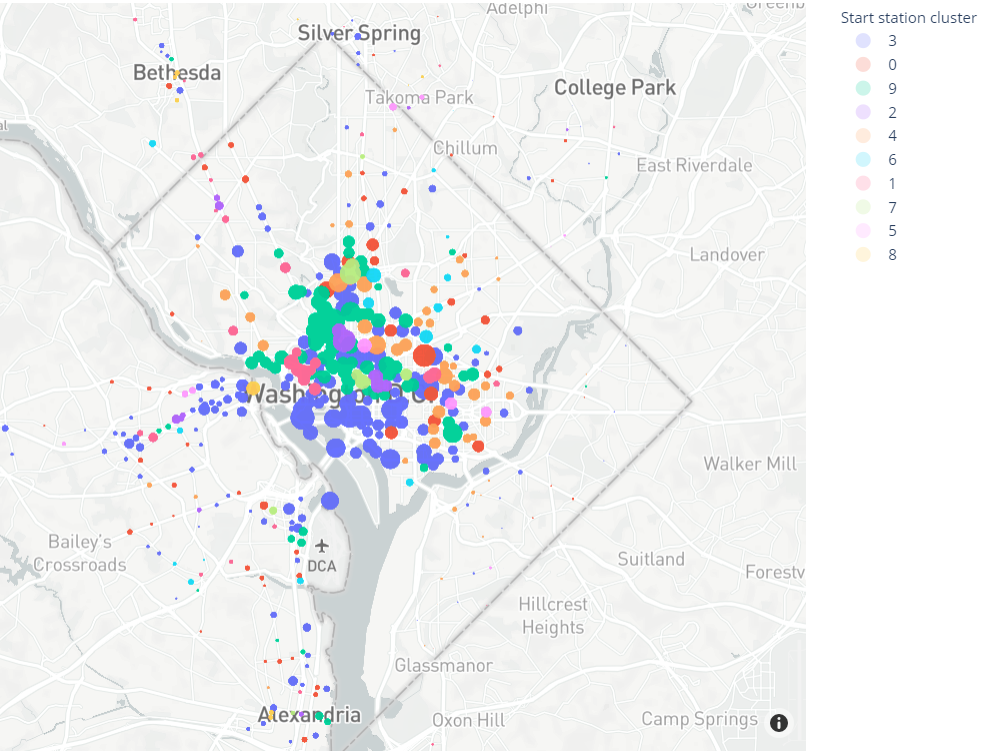

In [6]:
Image('../Capital-Bikeshare-Final-Project/Images/geo_map.PNG', width=500, height=500)

_To view an interactive map, please view "clusterGeomap.html" located in the repository_

To further examine the breakdown of our clusters, we generated a heatmap between cluster assignments and our categorical enrichment of the station tags. From this plot, we confirm that our clustering was effective and did result in several distinct clusters. For example, Cluster 1 corresponds to stations serving the political center of DC, which also happens to be where many tourist attractions are located. It lacks religious, healthcare, and transportation tags but is relatively high in all others, especially in government and tourist attractions. We further find that Cluster 2 corresponds to recreational and shopping areas as it is rich with dining, shopping, and entertainment tags. Clusters 3 and 4 are the health circles, and cluster 5 corresponds to the major religious activity centers and metro stations. Cluster 7 highlights stations primarily used to connect to other public transportation centers. Overall, this heatmap shows that our cluster assignments do an adequate job capturing information regarding the destinations around each station.

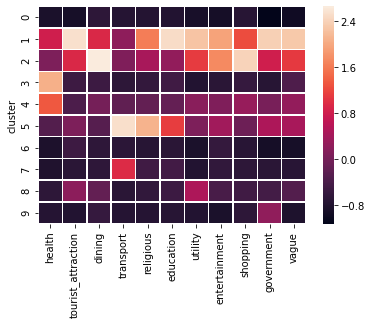

In [5]:
cluster_category = pd.read_csv("../Capital-Bikeshare-Final-Project/RelevantData/cluster_category_heatmap.csv", index_col = 0)
sns.heatmap(cluster_category, linewidth=0.5)

As one final check to ensure that our cluster assignments effectively group stations with similar nearby destinations, we conducted a kernal principal component analysis and color-coded the results by their cluster assignment in the plots below. After testing different kernel functions, a polynomal kernel was chosen because it yields the largest dominant eigen value. From the top figure, which plots the first and second principal components, we observe that cluster 2, 3, 4 and 7 show clear distinction from one another. And from the bottom figure, which plots the second and third principal components, we can see that cluster 8 was further distinguished. The results of kernal PCA and k-means show correspondance to each other. 

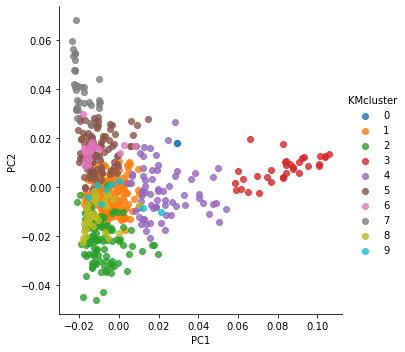

In [7]:
kpca = pd.read_csv("../Capital-Bikeshare-Final-Project/RelevantData/kernalPCA.csv")
sns.lmplot( x='PC1', y='PC2', data=kpca, fit_reg=False, hue='KMcluster', legend=True)

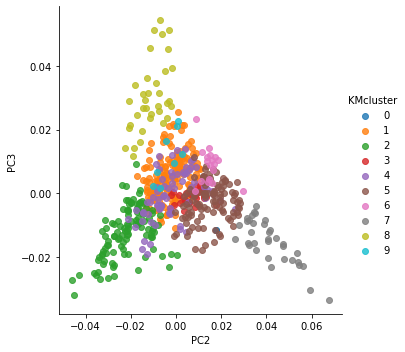

In [8]:
sns.lmplot( x='PC2', y='PC3', data=kpca, fit_reg=False, hue='KMcluster', legend=True)

The final cluster assignments can be viewed in _"station-cluster.csv"_. These assignments adequately group stations with similar destinations and provide a valuable new variable to capture information about a station's location. We plan to include this cluster variable into our forecasts of trips in the Capital Bikeshare network.

___

# Morning Rush Hour Forecasts

The primary objective of this analysis is to predict the number of daily trips made on a given route during the morning rush _(between 5:00 AM and 10:00 AM)_. We attempt to model two prediction tasks under this objective. The first is to predict whether any trip occurs along a specific route. This is the more challenging task to model. Since there are far more possible routes than users on any given day, our training data is quite sparse. With over 90% of routes unused each day, our binary models are prejudiced to predict that no trip occurs on each route. 

The second task is to predict how many trips will occur on a route once we know that at least one trip occurs. This task is a bit easier compared to the previous for two reasons. First, since this task only deals with routes that we know are used, past information and user popularity play a much larger role. Second, we add the variable of average duration to provide more information about the characteristics of a route.     

__Required Row Reduction__

During our planning, we found it necessary to artificially reduce the number of rows in our training dataset. With 591 total bike stations, there are a total of 349,281 routes that users can take on a given day. Given an entire year's worth of training data, this would result in a dataset with over 127 million rows. Unfortunately, none of our local machines are capable of handling this quantity of data and therefore, we were forced to constrain our analysis. 

Our solution was to choose a single cluster and analyze all possible routes starting from stations within that one cluster. This method reduced the number of rows from 349,281 down to 29,827; which gives us just under 11 million rows in this new training set. We examined the geographical distributions of each cluster and decided to focus our analysis on all trips starting from cluster 8 stations. We selected cluster 8 for three reasons. First, all stations in the cluster were within a bikeable distance to the downtown office center in Washington, DC. Second, many of the stations were near residential neighborhoods, making them more likely used during the morning rush period. And finally, there was a manageable number of stations in this cluster.

__Data Prperation__

The _"Pipeline()"_ function from _"DataPipeline.ipynb"_ generates the final datasets used in our analysis. The function takes in the cluster assignments, station locations, and raw trip data as input and returns one cohesive data frame which counts the number of trips made each day along each distinct route. The data for the entire 2019 calendar year was used as the training set while the data for January, February, and March 2020 was used as the testing set. 

The final dataset used as the basis for the remaining analysis is as follows:

> __Trip Key:__ _A primary key identifying each unique route_

> __Start Station ID:__ _A secondary key identifying the starting station_

> __End Station ID:__  _A secondary key identifying the ending station_

> __Start Station:__ _The name of the starting station (ex. "Metro Center - West")_

> __End Station:__ _The name of the ending station (ex. "Metro Center - East")_

> __Date:__ _The date in time-date format_

> __Month:__ _Integer from 1 to 12 extracted from Date_

> __Day of Week:__ _The day of the week as a str extracted from Date_

> __Average Duration:__ _The average duration of all trips made along a given route on a given day_

> __Total Trips:__ _the count of how many trips occurred between a given start station and a given end station between the hours of 5:00 AM and 10:00 AM on a given day_


### Predicting Which Routes are Used

In this section, we execute the binary prediction task to predict wheater any trip will occur along a route on a given day. We deploy both a random forest classifier as well as a deep neural network on our data to predict this event.

__Random Forest Classification__    

Random forest classification performed poorly on this dataset. Possibly affected by the highly sparse nature of the response variable, the model predicted '0' for all test entries. While we tried extensive tuning of this model, this problem could not be mediated by changing the maximum tree depth. Below is the confusion matrix of the random forest classifier model.

In [10]:
cm = pd.read_csv("RelevantData/RF_ConfMat.csv", index_col = 0)
cm

,Ture Negative,True Positive
Predicted Negative,7369468,231657
Predicted Positive,0,0


The code used for performing random forest classification can be found in the _"Binary_RandomForest.ipynb"_ notebook. 


__Deep Neural Network Classification__

A two-layered neural network was built with two ReLu activation layers and the Adam optimizer. This model outperformed the random forest classifier and produced true positives in its results. We further found the performance of this neural network increased with each added epoch, suggesting effective learning. The test accuracy of the neural network model was 96.9168%, with a true positive rate of 42.78% and a true negative rate of 97.05%. This imbalanced result is expected given the sparse nature of the labels. Below is the confusion matrix of the deep neural network classifier model after 6 training epochs.

In [11]:
cm_dnn = pd.read_csv("RelevantData/DNN_ConfMat.csv", index_col = 0)
cm_dnn

,True Negative,True Positive
Predicted Negative,7358780,10688
Predicted Positive,223666,7991


The ROC curve suggests rapid decay of precision with an increase of recall. This suggests that the model could be improved by further testing other neural net architectures. 

The code used for performing random forest classification can be found in the _"Binary_DNN.ipynb"_ notebook. 

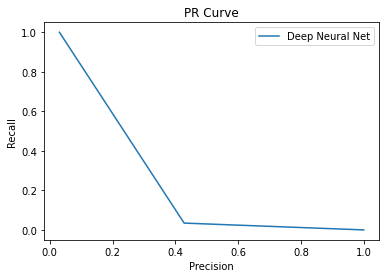

In [12]:
pr = pd.read_csv("RelevantData/Binary_DNN_PR.csv")
precision_keras = pr['Precision'].values
recall_keras = pr['Recall'].values
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(precision_keras, recall_keras, label='Deep Neural Net')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('PR Curve')
plt.legend(loc='best')
plt.show()

Given the challenge in predicting a binary classifier on a large and imbalanced dataset, achieving a 42.78% true positive rate is an exceptional performance given the strenuous conditions. Using only three predictors: the pair of stations, end station cluster, and date; our model correctly classified over 40% of all traversed routes on a given day. 

### Predicting Route Trip Rates

In this section, we summarize the regression task which predicts how many trips will occur along a route on a given day. We compare ridge regression, random forest regression, Poisson regression, and gradient tree boosting regression with a mean-value dummy regression to see if our machine learning models can out-perform the mean trip value. 

The histogram below demonstrates the true distribution of our training data. This histogram highlights its sparsity as more than $10^7$ observations have zero trips associated with them. Furthermore, most routes only have between zero and five trips on any given day. While this intuitively makes sense, as there are far more possible routes than users, it does pose a challenge for modeling the travel behavior. We also see that routes do occasionally see up to 20 trips in a day, but this occurrence is far too small to be considered a regular event. These large trips on a single route can likely be attributed to tourist groups traveling together. 

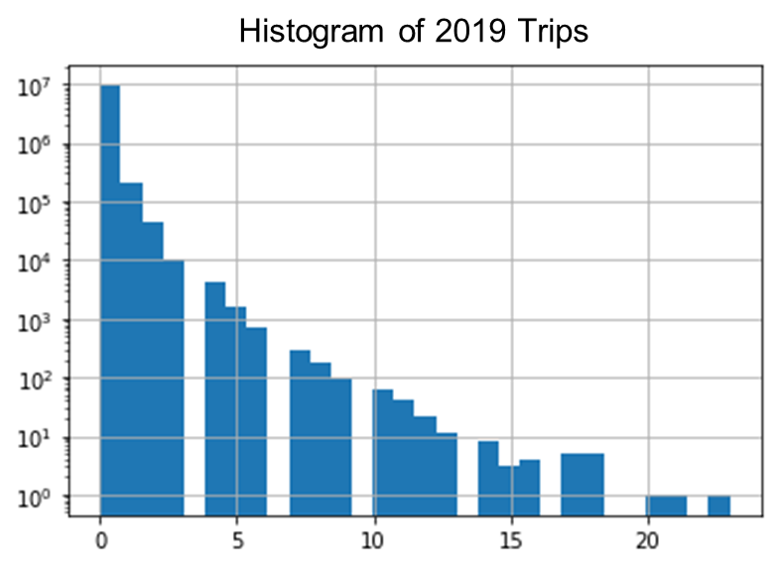

In [13]:
Image("../Capital-Bikeshare-Final-Project/Images/tripshist.png", width=370)

The table below compares the mean squared error (_MSE_), mean absolute error (_MAE_), and mean Poisson deviance (_MPD_) of each model on the training data. The mean value regressor, which just predicts the mean value across the entire dataset, returned an MSE of 0.037, an MAE of 0.066, and an MPD of 0.206. We can note that just guessing the mean value results in relatively low metrics since our data is heavily skewed right. Therefore, simply predicting the average value is a safe bet for any naive model. The ridge, random forest, and gradient tree boosting models all improved upon each of these metrics, while the Poisson regression showed no improvement over simply guessing the mean trip value. 

The full analysis can be viewed in "_Predicting-Route-Trip.ipynb_"

The best model across all three metrics for predicting the number of trips along each route is Gradient Tree Boosting. It has the lowest values of MSE, MAE, and MPD across all models. Furthermore, we will see that its predicted density is quite similar to the true density of the data.

|   _  | Mean Value Regressor | Ridge Regression | Poisson Regression | Random Forest | Gradient Tree Boosting| 
|------|-----------------|------------------|---------------------|---------------|-----------------------|
|MSE   |      0.037      |        0.029     |        0.037        |     0.008     |        0.007          |
|MAE   |      0.066      |        0.052     |        0.066        |     0.008     |        0.007          |
|MPD   |      0.206      |        0.114     |        0.206        |     0.220     |        0.004          |

The histogram below shows the true density of our training (2019) and testing (2020) data by the predicted density of each model. As we gathered from the evaluation metrics above, the ridge, random forest, and gradient boosted models return predicted densities relatively close to the true density in both training and testing sets. Furthermore, we also see that the Poisson regression performed exactly like the mean value regressor and simply predicted the average value across the entire data. Finally, we can confirm that the density of the gradient tree boosted model most closely matched the density of the true data set.

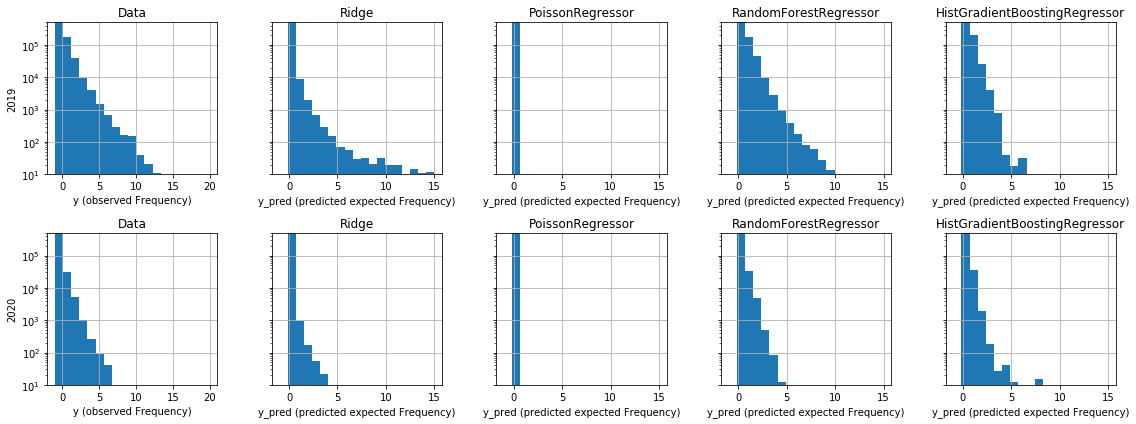

In [14]:
Image("../Capital-Bikeshare-Final-Project/Images/tripratehist1.png")

At this point, we should also discuss the strong assumption we made in the above regression models. Because we chose to take the perspective of predicting trip rates along routes knowing if at least one trip occurs, the above models all use "Average Duration" as a predictor variable. With almost 90% of our data having zero trips, the Average Duration of the trip is a direct indicator as to whether any trips take place. That is, if the average duration is zero, the models should know that no trip could have taken place. likewise, if the average duration is greater than zero, the models should know that at least one trip had to have taken place. 

However, it is also relevant to note that "Average Duration" only indicates the binary event that at least one trip takes place, which is why it was excluded from our binary classification task. It has no bearing on the total number of trips as it only indicates if at least one trip occurs. That is, if a route has an average duration of 12 minutes, there is no direct correspondence between that time and the total number of trips taken along that route. 

If the accuracy of our model only came from knowing this direct correlation, we would expect the predicted densities to look nothing like the true density. We would expect the model to be a perfect indicator as to if at least one trip occurred but have no accuracy predicting how many trips occurred. This is not the case here. The predicted densities of the ridge, random forest, and gradient tree boosted regressions all show a relatively high degree of similarity to the true density of the data. Therefore, from the perspective we took in this analysis, the ridge, random forest, and gradient tree boosted models are relevant and accurate predictors.  

While the duration of a future trip is unknown, if Capital Bikeshare managers want to predict how many trips will happen between a given route, they can estimate the duration from the past; and because the distance between stations remains constant, this average should be a good estimate for the future. Therefore, we accept the assumption that the knowledge of a trip's average duration will not bias our predictions of the total number of trips taken between a route. 

______________________________

### __Validating the Main Model Assumption__

We recognize this is a strong assumption to make. Therefore, we will show this assumption holds by re-training the same models on modified data. In this case, the modified data is created by eliminating trips greater than 120 minutes, eliminating trips less than 2 minutes, and filtering out all rows with zero trips. This method is consistent with Beecham and Wood, 2014. 

If our assumption is indeed accurate, we would expect these re-trained models to have a similar performance as the models trained on the full dataset. If these two sets of models are similar, we have shown that knowledge of a trip's average duration does not introduce important bias into them.

The analysis conducted on the modified data can be examined in "_AssumptionCheck.ipynb_"


___Performance on testing data___

In the table below, we show each model's performance after being trained on the modified data. As expected, the results are similar to what was achieved above. The Poisson regression still shows no change from the mean value regressor. The ridge regression has only a marginal decrease in both its MSE and MAE compared with the naive mean value model; and both random forest and gradient tree models are battling for the best performance. 

|   _  | Mean Value Regressor | Ridge Regression | Poisson Regression |Random Forest | Gradient Tree Boosting| 
|------|----------------------|------------------|--------------------|--------------|-----------------------|
|MSE   |      0.359      |        0.357     |       0.359             |   0.452     |        0.343          |
|MAE   |      0.462      |        0.427     |       0.462             |  0.397      |        0.416          |
|MPD   |      0.547      |        0.511     |       0.547             | 0.188       |        0.486          |

In this case, it appears that with the absence of the rows corresponding to routes without trips, the random forest may have overfitted the training data. The random forest achieved an MSE of 0.110, MAE of 0.184, & MPD of 0.046 on the training data and has a near-perfect distribution. We can see evidence of overfitting as the MSE for the random forest on the testing data surpassed the MSE for the naive mean value mode. While the MAE and MPD for the random forest regressor are both great improvements from the naive mean value, the skewed MSE is evidence that the model overfitted given the modified data.

Plotting the distributions of each model's predicted trip rates with the true density of our testing data. We confirm that the predictions of each model on the testing set are of similar accuracy as our original results. The random forest regression returns a density closest to that of the true data. But recall, that we believe the random forest may have overfitted on the training data. The gradient tree boosted model is the next closest but is slightly more right-skewed. Finally, the ridge model is the most right-skewed, just as before. 

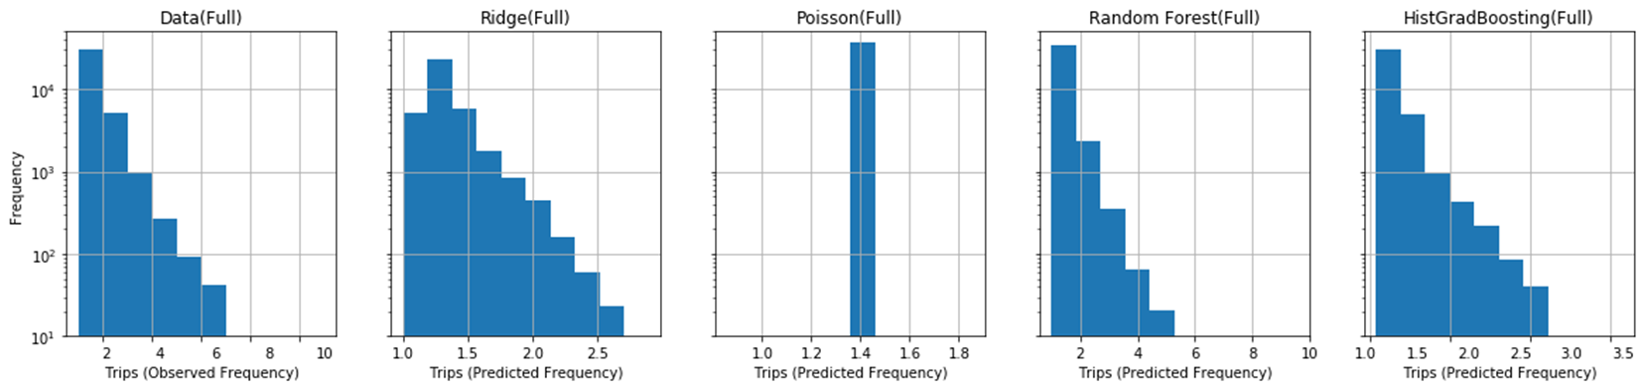

In [15]:
Image("../Capital-Bikeshare-Final-Project/Images/tripratehist3.png", width=950)


From this sanity check, we feel comfortable accepting the assumption that knowledge of a trip's average duration does not significantly bias our models. On both the original and modified dataset, the gradient tree boosted model performed the best on each testing set. Therefore, in our model evaluation, we will select gradient tree boosting as our best model to predict the number of trips that occur over each daily route. 

____________________________________________

# Conclusion & Discussion

The purpose of this project was to estimate the daily number of trips between each route in the Capital Bikeshare network during the morning rush. We accomplished this task through three primary phases. First, we clustered each station based on the characteristics of the surrounding destinations. Next, we used these clusters as a new variable to predict if any trips occurred along each route. And finally, we predicted the total number of trips that will occur on each route during the morning rush. Overall, our machine learning methods were quite effective at identifying stations in similar metropolitan areas and predicting the different trip rates along routes between these stations. 

The clustering step provided a sociological context for each of the different bike routes and added relevant information into our project's predictions. To cluster stations, we integrated the Google Places API with the latitudinal and longitudinal coordinates of each Captial Bikeshare station. We did this to understand and quantify the different urban destinations in proximity to each station. Our cluster assignments suggest that the bike station clusters formed distinct groups that corresponded to different geographical and functional zones of Washington DC. Results generated from independent clustering methods converged and supported each other. 

With each station assigned to a cluster, we worked toward our final goal of predicting the trip rates on different routes. We accomplished this in two phases; the first was a binary classification task which predicted wheater a route would be used at least once on a given day's morning rush. The second task focused on predicting the total number of trips along each route provided we knew the true result of the first task.

The primary challenge of the classification task was the imbalance of labels. There are many more class '0' entries than class '1', and since we wanted to keep the temporal nature inherent to our data, we could not perform common balancing protocols. We tested random forest and deep neural net classification. The random forest model could not overcome the problem of imbalanced labels and yielded all-0 predictions for the test set. The deep neural net outperformed the random forest model after only 6 epochs of training. The neural network correctly classified over 95% of the data and boasts a 42.78% true positive rate. While this is not a perfect result, it is a substantial improvement over other naive methods.  

The regression task saw better performance from its models, as the imbalance in our data did not impact them as heavily as the random forest. For this task, we trained ridge, random forest, Poisson, and gradient tree boosted regressions. Of these, the Poisson was as useless as any naive model, simply predicting the mean number of trips for every observation. The tree methods, random forest, and gradient tree boosting performed the best, achieving prediction distributions very similar to the true distribution of our data across both testing and training. 

While these models performed better, they heavily rely on two major assumptions. The first is that the average duration of a trip is known before the trip occurs. This is a relatively easy assumption to accept as past data or experience can be substituted and yield an approximate estimate. The second assumption is that training the models using average duration does not significantly bias the model's predictions. Since knowing the average duration implies whether at least one trip occurred but not the number of trips that occur, we needed to check if this dependence would significantly skew our predictions. After re-training the same models on a modified dataset, we found that the performance of the models was not significantly impacted by the average duration predictor.

With that, we concluded our analysis into the Capital Bikeshare network. While we achieved many positive results, there were several questions and topics of further study we thought relevant to include here. First, Did the cluster information enhance the prediction accuracy? We did not test how our predictions would change if we omitted or altered the clustering criteria. Examining the sensitivity of our models on the cluster assignments would be an interesting extension of this report. Secondly, Could more epochs have improved the performance of the deep neural net model for binary prediction? A small epoch was chosen to train the neural net due to limited computational power. The prediction accuracy was still increasing when the training step ended. Therefore, we have reasons to believe that the performance will continue to increase with more epochs. This hypothesis could be easily tested with access to a more powerful computer. Finally, we would like to see this analysis done across the entire network. Due to computational limitations, we had to restrict our data to trips originating from one cluster. We think it would be interesting to see the results of this work expanded to include all 349,281 possible routes.

# References

Bao, Jie, et al. &quot;Exploring bikesharing travel patterns and trip purposes using smart card data and online
point of interests.&quot; Networks and Spatial Economics 17.4 (2017): 1231-1253.

Beecham, Roger, and Jo Wood. &quot;Exploring gendered cycling behaviours within a large-scale behavioural
data-set.&quot; Transportation Planning and Technology 37.1 (2014): 83-97.

Faghih-Imani, Ahmadreza, and Naveen Eluru. &quot;Incorporating the impact of spatio-temporal interactions on
bicycle sharing system demand: A case study of New York CitiBike system.&quot; Journal of Transport
Geography 54 (2016): 218-227.

Zhao, Jinbao, Jian Wang, and Wei Deng. &quot;Exploring bikesharing travel time and trip chain by gender and
day of the week.&quot; Transportation Research Part C: Emerging Technologies 58 (2015): 251-264.